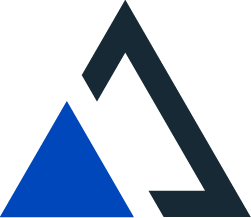

<h1><font color='#0047BB'>Semantic Inference: Non-UDF Integration</font></h1>

<h3><font color='#0047BB'>Introduction</h3>

With Semantic Inference, AI-Link users can embed machine learning models directly in their AtScale data models, allowing ML model predictions to be generated and consumed on-demand through the BI tools of your choice. Semantic Inference allows organizations to save time and compute otherwise associated with ML model deployment, whether by leveraging AtScale’s query optimization engine to generate predictions or by serving model outputs directly to business stakeholders via the BI tools of their choice.

This section explains how to embed machine learning models (particularly linear and logistic regression models) into the Semantic Layer *without* the support of user-defined functions (UDFs).


In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from atscale.client import Client
from atscale.data_model import DataModel
from atscale.eda import feature_engineering

<h3><font color='#0047BB'>Connect to AtScale</h3>

In [3]:
client = Client(
    server=...,
    username=...,
    organization=...,
)

client.connect()

project = client.select_project(draft_project_id=...)

data_model = project.select_data_model(data_model_id=...)

Please choose a published project:
Automatically selecting only option: "ID: d33bda47-64f2-4600-5138-d9585e2620c0: Name: Sales Insights"
Please choose a data model:
Automatically selecting only option: "ID: b89a2fb7-74f4-4828-706e-70f7186e10a0: Name: Internet Sales Cube"


<h3><font color='#0047BB'>Get Training Data From Your AtScale Data Model</h3> 

Our goal here is to forecast total sales as a function of customer count, aggregated at the state level (i.e., sales in Massachusetts, Texas, etc.):

In [4]:
df = data_model.get_data(
    feature_list=[
        "State",
        "customercount1",
        "salesamount1",
    ],
)

You’ll need to consider the response row limit configured in your AtScale settings when fetching training data; if the row limit poses an issue, consider using `get_data` filters to exclude irrelevant data or using `get_data_direct` to avoid the row limit altogether.

<h3><font color='#0047BB'>Train Your Model</h3> 

In the below cell, we train a linear regression model to forecast sales as a function of customer count.

In [5]:
# convert data to NumPy arrays
X = df[["customercount1"]].to_numpy()

y = df[["salesamount1"]].to_numpy()

# split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7,)

# train model
regression_model = LinearRegression().fit(X_train, y_train)

# evaluate model on test data
print(f"R^2 score on test data: {regression_model.score(X_test, y_test)}")

R^2 score on test data: 0.876581928886952


<h3><font color='#0047BB'>Embed Your Model in the Semantic Model</h3> 

We can now embed this linear regression model in our semantic model as an aggregated feature:

In [6]:
feature_engineering.write_linear_regression_model(
    data_model=data_model,
    regression_model=regression_model,
    new_feature_name="FORECASTED_SALESAMOUNT1",
    granularity_levels=["State"],
    feature_inputs=["customercount1"],
)

The model will now automatically generate predictions based on the latest data available in your connected warehouse, and AtScale will enable easy, BI-consumable aggregation over the predictions.